<a href="https://www.kaggle.com/code/andrewbaum/binary-classification-of-fire-alarm-data?scriptVersionId=120213009" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# About the dataset

Collection of training data is performed with the help of IOT devices since the goal is to develop a AI based smoke detector device.
Many different environments and fire sources have to be sampled to ensure a good dataset for training. A short list of different scenarios which are captured:

    Normal indoor
    Normal outdoor
    Indoor wood fire, firefighter training area
    Indoor gas fire, firefighter training area
    Outdoor wood, coal, and gas grill
    Outdoor high humidity
    etc.

The dataset is nearly 60.000 readings long. The sample rate is 1Hz for all sensors. To keep track of the data, a UTC timestamp is added to every sensor reading. 


**Aim:** Binary classification of fire alarm data to determine wether or not there is a fire

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/smoke-detection-dataset/smoke_detection_iot.csv


In [2]:
data = pd.read_csv(r'/kaggle/input/smoke-detection-dataset/smoke_detection_iot.csv')

In [3]:
data.head()

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0
1,1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1,0
2,2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,2,0
3,3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,3,0
4,4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,4,0


In [4]:
#drop extra column
data.drop('Unnamed: 0',axis=1,inplace=True)

In [5]:
#lets also drop detector count and time data
data.drop(['UTC', 'CNT'],axis=1,inplace=True)

In [6]:
data.head()

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm
0,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0
1,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,0
2,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,0
3,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,0
4,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,0


In [7]:
data.shape

(62630, 13)

In [8]:
data.columns

Index(['Temperature[C]', 'Humidity[%]', 'TVOC[ppb]', 'eCO2[ppm]', 'Raw H2',
       'Raw Ethanol', 'Pressure[hPa]', 'PM1.0', 'PM2.5', 'NC0.5', 'NC1.0',
       'NC2.5', 'Fire Alarm'],
      dtype='object')

In [9]:
data.dtypes

Temperature[C]    float64
Humidity[%]       float64
TVOC[ppb]           int64
eCO2[ppm]           int64
Raw H2              int64
Raw Ethanol         int64
Pressure[hPa]     float64
PM1.0             float64
PM2.5             float64
NC0.5             float64
NC1.0             float64
NC2.5             float64
Fire Alarm          int64
dtype: object

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature[C]  62630 non-null  float64
 1   Humidity[%]     62630 non-null  float64
 2   TVOC[ppb]       62630 non-null  int64  
 3   eCO2[ppm]       62630 non-null  int64  
 4   Raw H2          62630 non-null  int64  
 5   Raw Ethanol     62630 non-null  int64  
 6   Pressure[hPa]   62630 non-null  float64
 7   PM1.0           62630 non-null  float64
 8   PM2.5           62630 non-null  float64
 9   NC0.5           62630 non-null  float64
 10  NC1.0           62630 non-null  float64
 11  NC2.5           62630 non-null  float64
 12  Fire Alarm      62630 non-null  int64  
dtypes: float64(8), int64(5)
memory usage: 6.2 MB


In [11]:
data.isna().sum()

Temperature[C]    0
Humidity[%]       0
TVOC[ppb]         0
eCO2[ppm]         0
Raw H2            0
Raw Ethanol       0
Pressure[hPa]     0
PM1.0             0
PM2.5             0
NC0.5             0
NC1.0             0
NC2.5             0
Fire Alarm        0
dtype: int64

The data is already clean :)

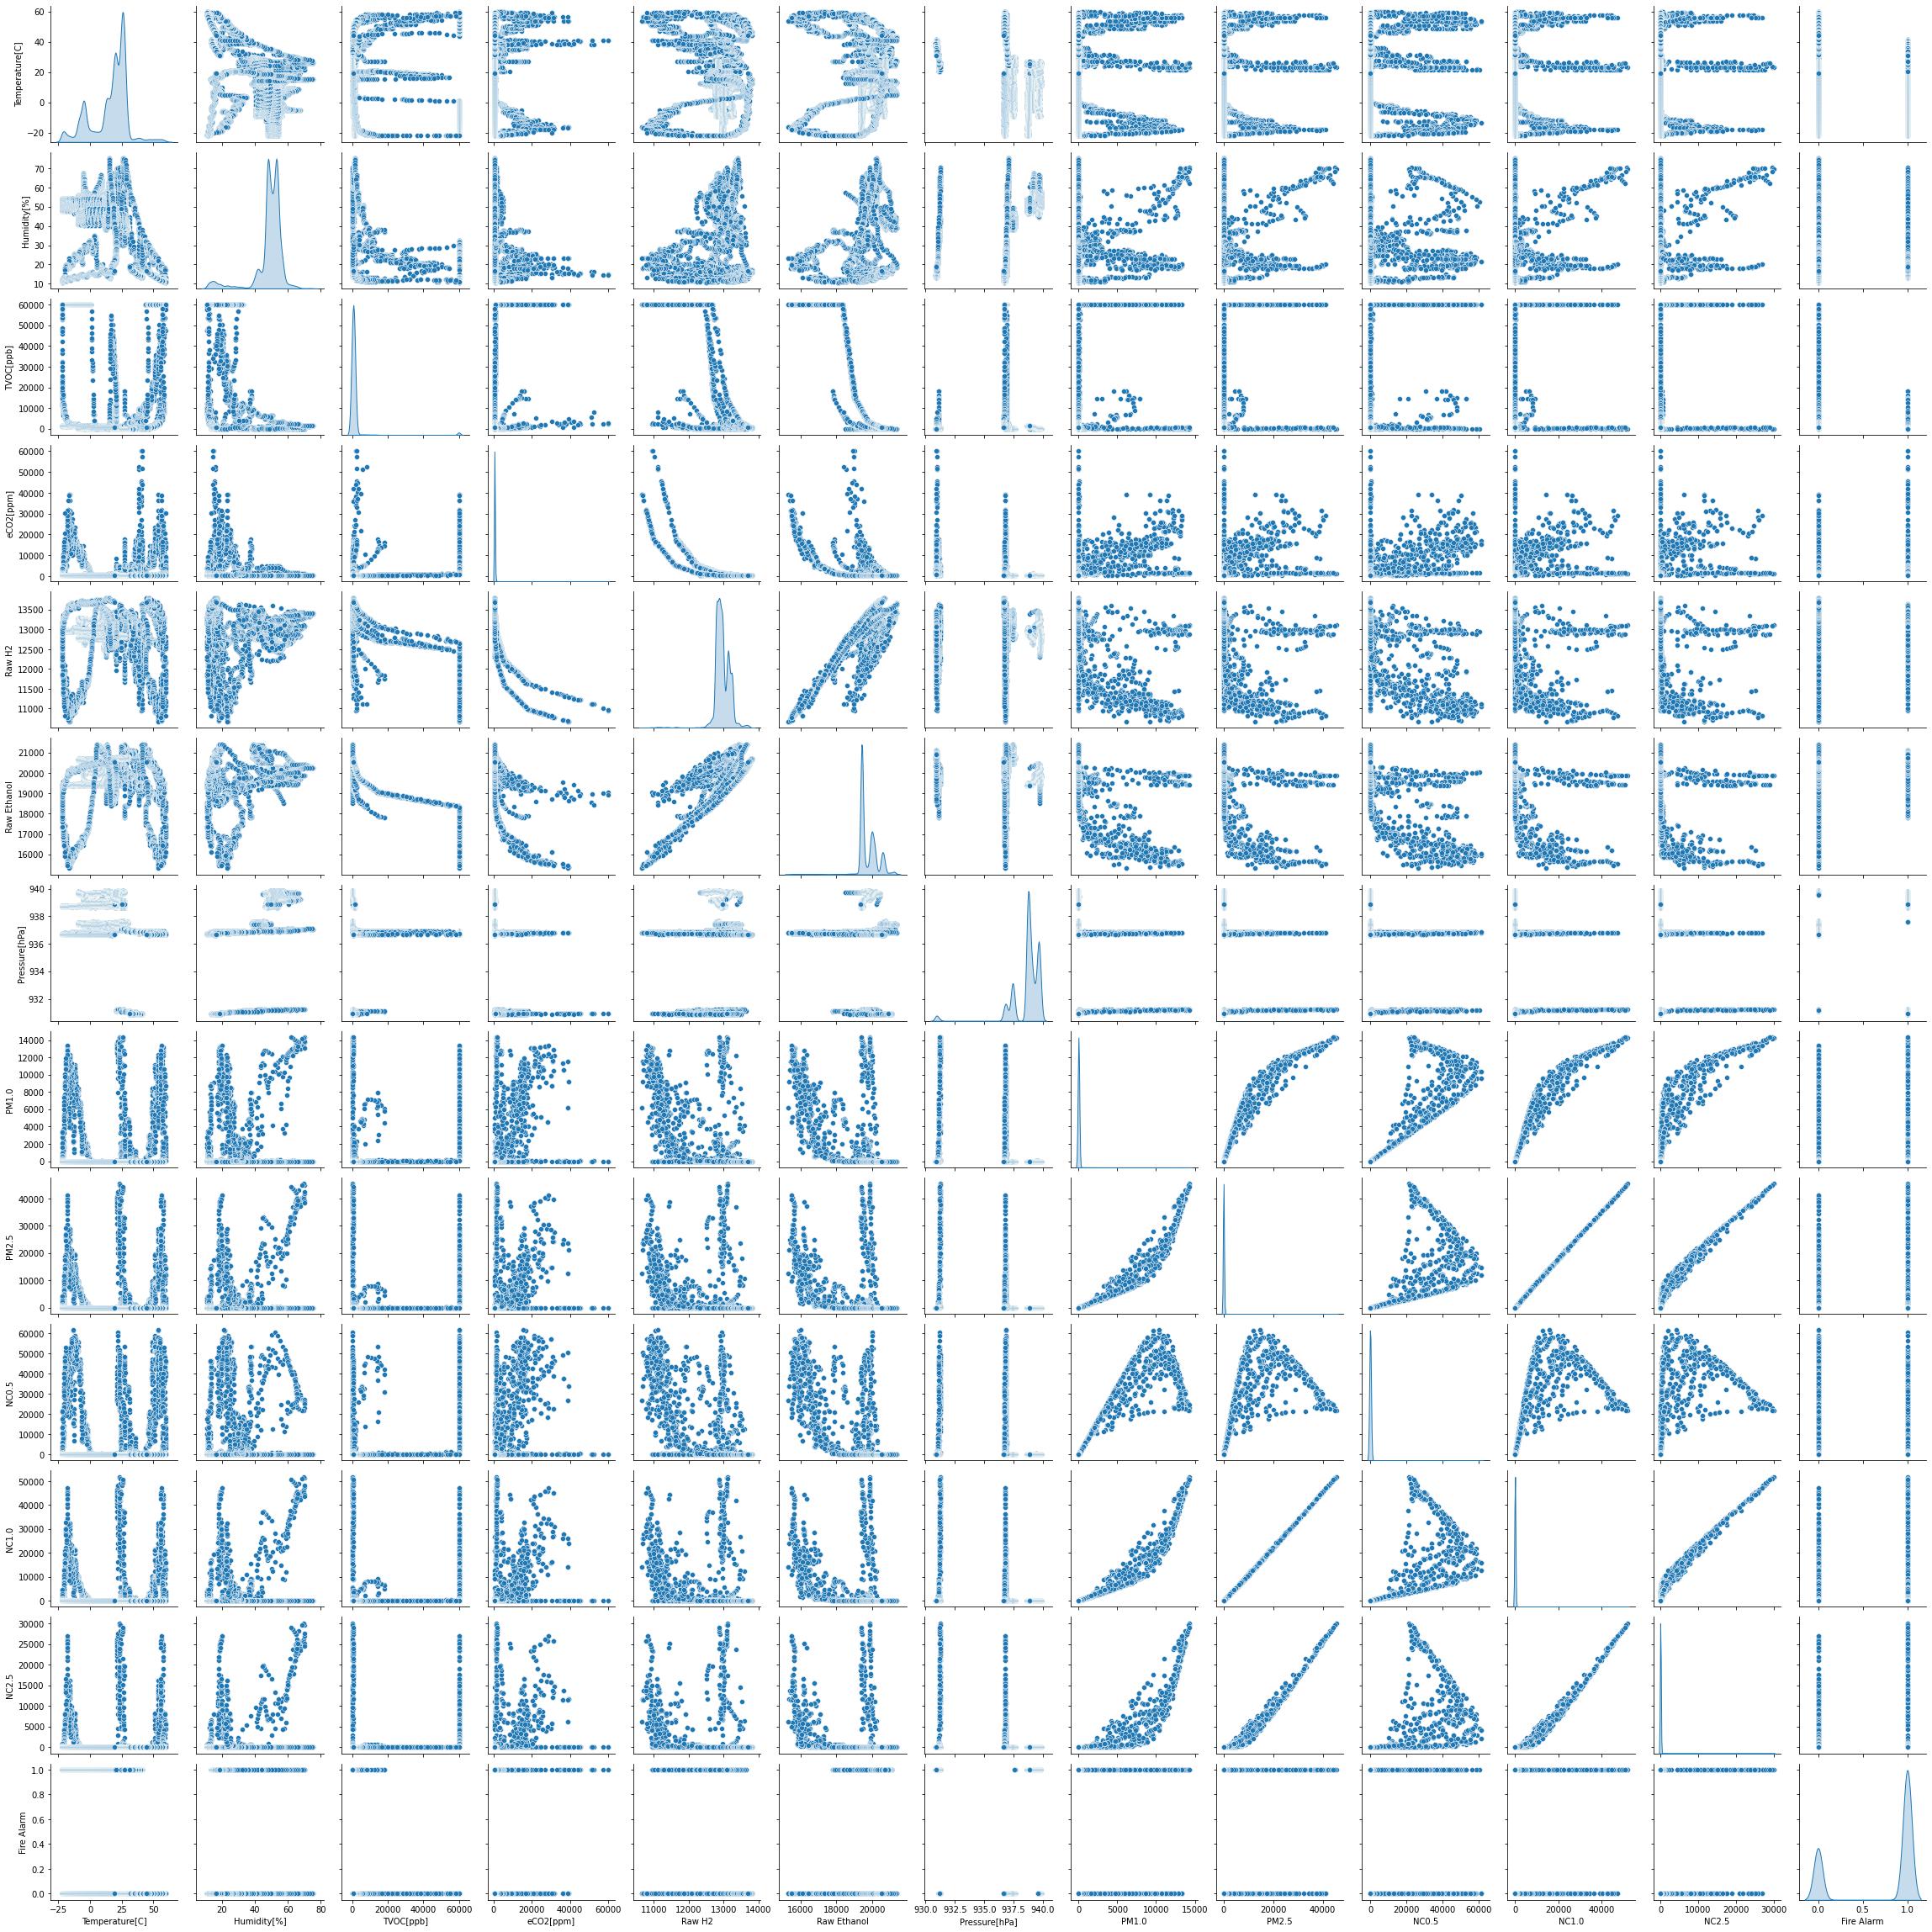

In [12]:
sns.pairplot(data, diag_kind='kde')

In [13]:
corr=data.corr()
corr

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm
Temperature[C],1.000000,-0.243986,0.082442,0.079265,-0.135540,-0.037343,-0.251203,0.037330,0.032084,0.039291,0.031608,0.025526,-0.163902
Humidity[%],-0.243986,1.000000,-0.488878,-0.369095,0.247199,0.068782,0.694614,-0.236538,-0.178882,-0.277389,-0.174224,-0.118502,0.399846
TVOC[ppb],0.082442,-0.488878,1.000000,0.606118,-0.653053,-0.673715,-0.220004,0.597366,0.477424,0.670657,0.467386,0.344721,-0.214743
eCO2[ppm],0.079265,-0.369095,0.606118,1.000000,-0.682785,-0.506695,-0.326043,0.665482,0.572691,0.699604,0.564252,0.456323,-0.097006
Raw H2,-0.135540,0.247199,-0.653053,-0.682785,1.000000,0.631495,0.303090,-0.530714,-0.431079,-0.587769,-0.422626,-0.318518,0.107007
Raw Ethanol,-0.037343,0.068782,-0.673715,-0.506695,0.631495,1.000000,-0.075926,-0.480698,-0.393192,-0.529186,-0.385720,-0.293351,-0.340652
Pressure[hPa],-0.251203,0.694614,-0.220004,-0.326043,0.303090,-0.075926,1.000000,-0.258938,-0.243071,-0.248657,-0.241148,-0.213390,0.249797
PM1.0,0.037330,-0.236538,0.597366,0.665482,-0.530714,-0.480698,-0.258938,1.000000,0.956118,0.940045,0.949860,0.854901,-0.110552
PM2.5,0.032084,-0.178882,0.477424,0.572691,-0.431079,-0.393192,-0.243071,0.956118,1.000000,0.798873,0.999787,0.969382,-0.084916
NC0.5,0.039291,-0.277389,0.670657,0.699604,-0.587769,-0.529186,-0.248657,0.940045,0.798873,1.000000,0.786274,0.626711,-0.128118


<AxesSubplot:>

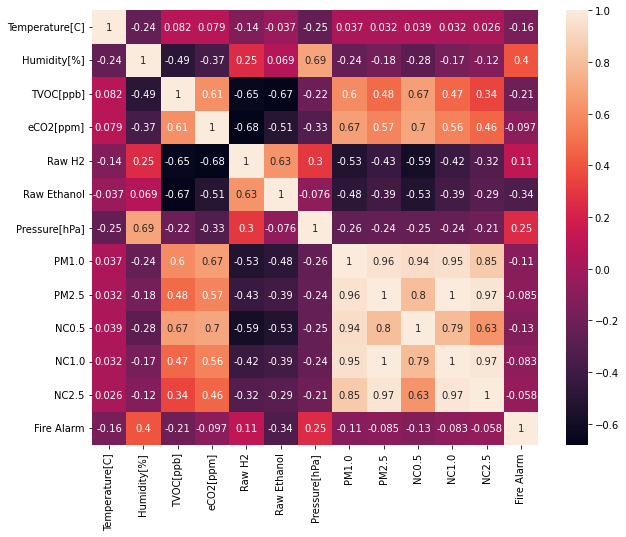

In [14]:
plt.figure(figsize=(10,8))
sns.heatmap(corr,annot=True)

**Values which are highly correlated:**
<br>PM1.0 - Paticulate matter of diameter less than 1.0 micrometer .
<br>PM2.5 - Paticulate matter of diameter less than 2.5 micrometer.
<br>NC0.5 - Concentration of particulate matter of diameter less than 0.5 micrometers.
<br>NC1.0 - Concentration of particulate matter of diameter less than 1.0 micrometers.
<br>NC2.5 - Concentration of particulate matter of diameter less than 2.5 micrometers.
<br>
<br>
<br>
<br>
**They are all data points related to particulate matter, and some have a correlation close to 1. Having so many highly correlated features may be bad for the model.**

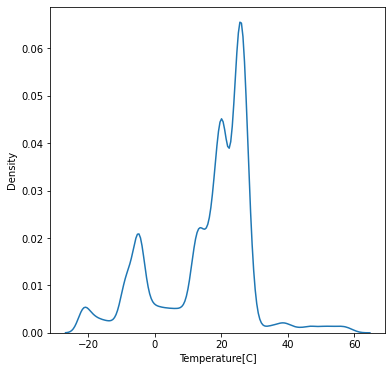

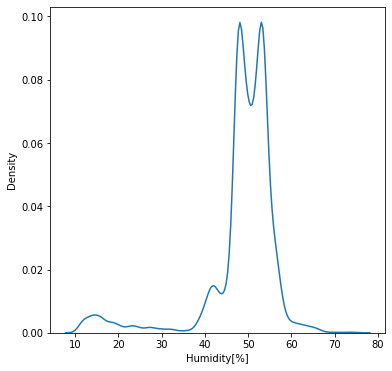

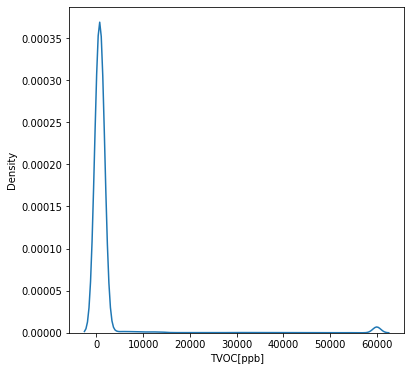

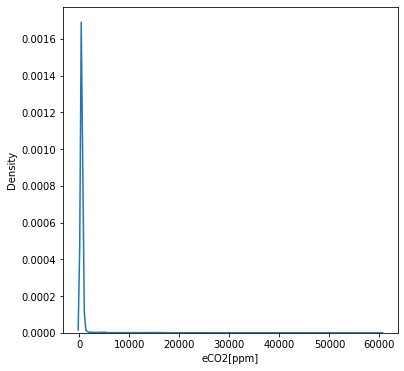

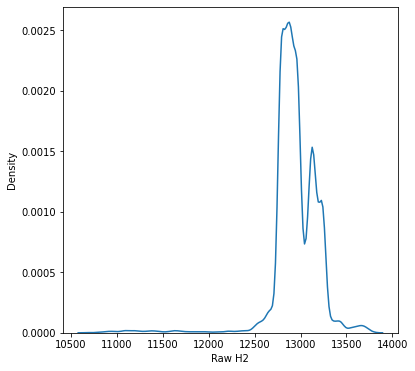

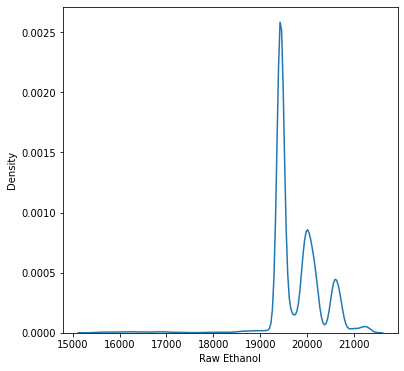

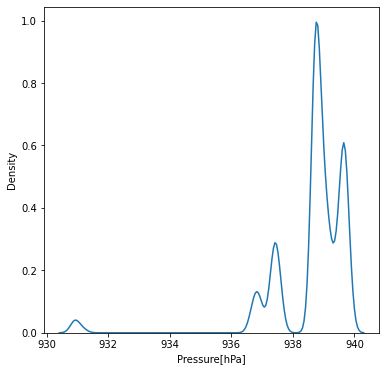

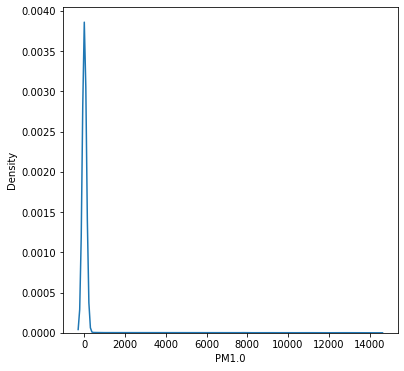

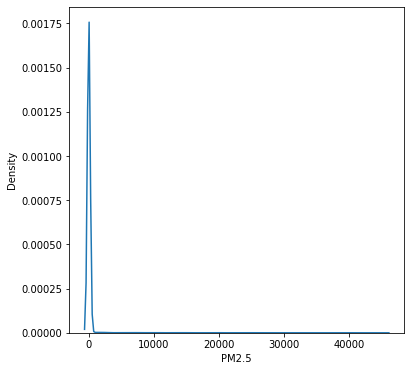

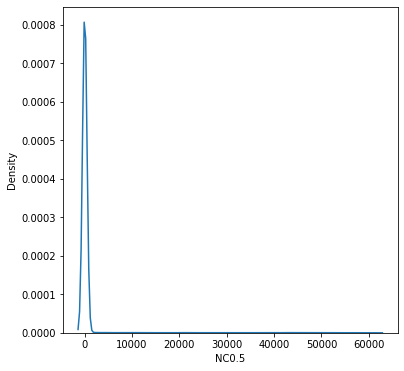

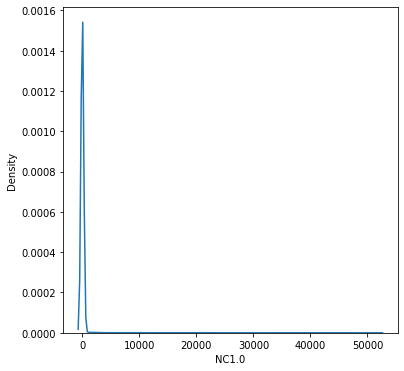

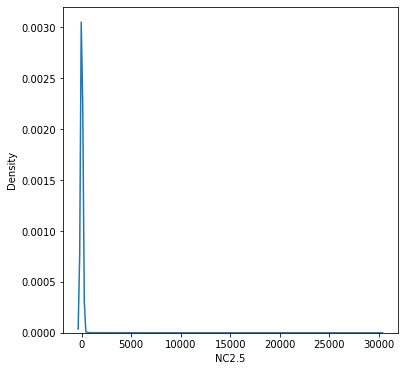

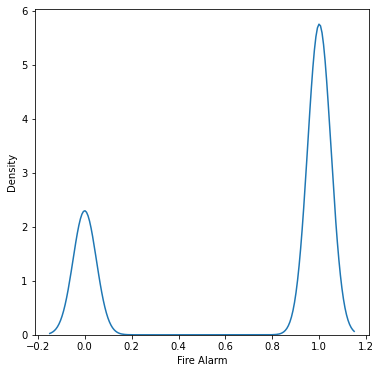

In [15]:
for c in ['Temperature[C]', 'Humidity[%]', 'TVOC[ppb]', 'eCO2[ppm]',
       'Raw H2', 'Raw Ethanol', 'Pressure[hPa]', 'PM1.0', 'PM2.5', 'NC0.5',
       'NC1.0', 'NC2.5', 'Fire Alarm']:

    plt.figure(figsize = (6,6))
    sns.kdeplot(data = data,x = c)

    plt.show()

# Modeling

In [16]:
X = data.drop('Fire Alarm', axis=1)
y=data['Fire Alarm']

In [17]:
X.head()

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5
0,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0
1,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0
2,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0
3,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0
4,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0


In [18]:
#split to train test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [19]:
#scale the data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
#test 8 different models 
classifiers = {
    "KNN": KNeighborsClassifier(), 
    "LR": LogisticRegression(max_iter=1000), 
    "DT": DecisionTreeClassifier(),
    "RF": RandomForestClassifier(),
    "SVM": SVC(),
    "MLP": MLPClassifier(max_iter=1000),
    "XGB": XGBClassifier(),
    "LGBM": LGBMClassifier()
}

results = pd.DataFrame(columns=["Classifier", "Avg_Accuracy", "Avg_F1_Score"])
for name, clf in classifiers.items():
    model = clf
    cv_results = cross_validate(
        model, X_train_scaled, y_train, cv=10,
        scoring=(['accuracy', 'f1'])
    )

    results = results.append({
        "Classifier": name,
        "Avg_Accuracy": cv_results['test_accuracy'].mean(),
        "Avg_F1_Score": cv_results['test_f1'].mean()
    }, ignore_index=True)
    
results["Avg_Overall"] = (results["Avg_Accuracy"] + results["Avg_F1_Score"]) / 2
results = results.sort_values("Avg_Overall", ascending=False)
results

,Classifier,Avg_Accuracy,Avg_F1_Score,Avg_Overall
3,RF,0.999851,0.999896,0.999873
6,XGB,0.999851,0.999896,0.999873
7,LGBM,0.999830,0.999881,0.999855
2,DT,0.999787,0.999851,0.999819
5,MLP,0.998978,0.999286,0.999132
0,KNN,0.998233,0.998765,0.998499
4,SVM,0.966448,0.976899,0.971674
1,LR,0.897130,0.929815,0.913473


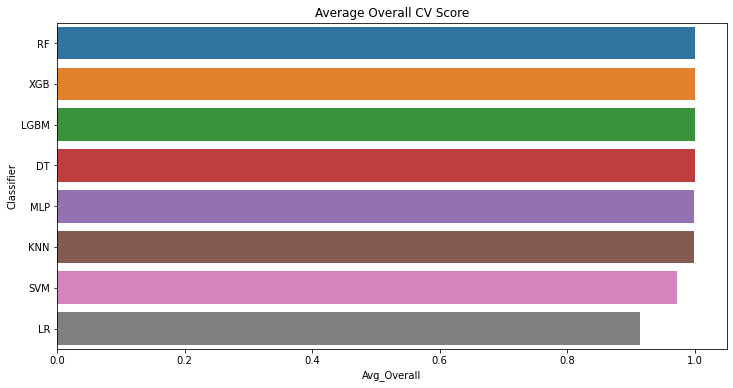

In [21]:
plt.figure(figsize=(12, 6))
sns.barplot(data=results, x="Avg_Overall", y="Classifier")
plt.title("Average Overall CV Score")
plt.show()

[0.07343528 0.08590533 0.18147193 0.0093377  0.05778877 0.21421525
 0.2376581  0.0328728  0.02971442 0.03061169 0.02907122 0.01791751]


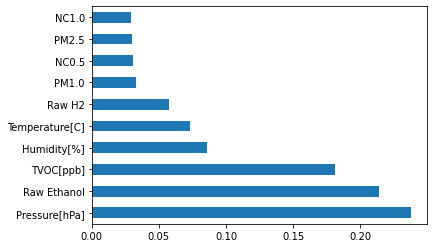

In [22]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
#use inbuilt class feature_importances of tree based classifiers
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) 
#plot graph of feature importances 
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

# Dropping Highly Correlated Features

The accuracy of each model is very high, so now highly correlated features will be dropped. Hopefully this will lower the chances of overfitting and improve the model. 

In [23]:
data.head()

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm
0,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0
1,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,0
2,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,0
3,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,0
4,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,0


In [24]:
X = data.drop(['Fire Alarm', 'NC1.0', 'NC0.5', 'PM2.5'], axis=1)
y=data['Fire Alarm']

In [25]:
X.head()

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,NC2.5
0,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0
1,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0
2,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0
3,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0
4,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0


In [26]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)

In [27]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
classifiers = {
    "KNN": KNeighborsClassifier(), 
    "LR": LogisticRegression(max_iter=1000), 
    "DT": DecisionTreeClassifier(),
    "RF": RandomForestClassifier(),
    "SVM": SVC(),
    "MLP": MLPClassifier(max_iter=1000),
    "XGB": XGBClassifier(),
    "LGBM": LGBMClassifier()
}

results = pd.DataFrame(columns=["Classifier", "Avg_Accuracy", "Avg_F1_Score"])
for name, clf in classifiers.items():
    model = clf
    cv_results = cross_validate(
        model, X_train_scaled, y_train, cv=10,
        scoring=(['accuracy', 'f1'])
    )

    results = results.append({
        "Classifier": name,
        "Avg_Accuracy": cv_results['test_accuracy'].mean(),
        "Avg_F1_Score": cv_results['test_f1'].mean()
    }, ignore_index=True)
    
results["Avg_Overall"] = (results["Avg_Accuracy"] + results["Avg_F1_Score"]) / 2
results = results.sort_values("Avg_Overall", ascending=False)
results

,Classifier,Avg_Accuracy,Avg_F1_Score,Avg_Overall
3,RF,0.999830,0.999881,0.999855
7,LGBM,0.999830,0.999881,0.999855
2,DT,0.999787,0.999851,0.999819
6,XGB,0.999766,0.999837,0.999801
5,MLP,0.999297,0.999510,0.999404
0,KNN,0.998169,0.998722,0.998446
4,SVM,0.970174,0.979414,0.974794
1,LR,0.897769,0.930332,0.914050


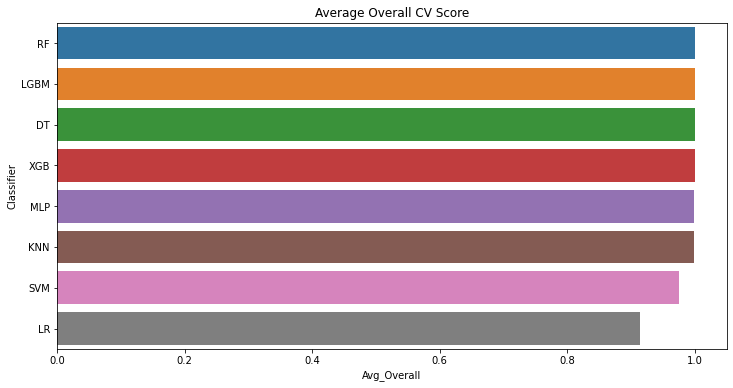

In [29]:
plt.figure(figsize=(12, 6))
sns.barplot(data=results, x="Avg_Overall", y="Classifier")
plt.title("Average Overall CV Score")
plt.show()